In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
import warnings

##### This data set is chosen because it has 17 columns, which is not too much and not too low. As it is also a practical dataset, and its usage scanerio is the grouping people into different categories for the marketing process, based on the parameters such as education, housing and loan etc. I belive that I will learn in using this data. And it also has sufficient data as it has over four thousand rows, which is a sweet spot for learning and interacting with the data as it is not to time consuming but enough for applying the lessons learnt. These are the reason that I chose to use the dataset. 
###### This is the link that I got the dataset https://archive.ics.uci.edu/dataset/222/bank+marketing

In [319]:
warnings.filterwarnings('ignore')

In [320]:
df=pd.read_csv("bank.csv", sep=";")
df=df.drop(columns='y', )
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown


In [321]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

##### There are no missing values in this dataset.

In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
dtypes: int64(7), object(9)
memory usage: 565.3+ KB


##### As the dataset contains objects and int values we have to convert objects into numeric values using one hot encoding, because there is no order in the data, although month can be ordered, we can also make it ordinal to make the process simpler.

##### Firstly, the data includes yes and no values, as it will double the number of columns if we have used one hot encoding; we map yes with 1 and no with 0. 

In [323]:
col_to_map = ['default','housing', 'loan']
mapping_dict = {'yes': 1, 'no': 0}
for col in col_to_map:
    df[col] = df[col].map(mapping_dict)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown


##### We will try to create a pipeline where we will try to one hot encode the categorical columns into numeric columns, and then try to scale all of the dataset using standard scaler because, if we only scale for numeric columns, the scaled data and one hot encoded 1 and 0 will not be meaningful together. 

In [324]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), cat_cols)],
    remainder='passthrough' 
)

pre_processor = Pipeline(steps=[
    ('encoder', encoder),
    ('scaler', StandardScaler())
])

processed_array = pre_processor.fit_transform(df)

new_column_names = pre_processor.get_feature_names_out()
processed_df = pd.DataFrame(data=processed_array, index=df.index, columns=new_column_names)

##### And when I look for the online resources about reducing the number of columns in kmean clustoring, they usually use loading values, and try to understand the most impactful columns towards the classification process. 
##### When we look for the values, highest values are columns splited from 'poutcome', 'previous', 'pdays', 'contact', 'month' and 'education' columns. 
##### Therefore we will try to consider calculating the WCSS and slihouette scores with all of the columns first, and try to calculate only with the given five columns, and compare the results. 

In [325]:
pca = PCA()
pca.fit(processed_df)

loadings = pd.DataFrame(
    np.abs(pca.components_[0]), 
    index=processed_df.columns, 
    columns=['Impact']
).sort_values(by='Impact', ascending=False)

loadings

,Impact
cat__poutcome_unknown,0.448650
remainder__pdays,0.407588
remainder__previous,0.352244
cat__poutcome_failure,0.340827
cat__contact_unknown,0.318405
cat__contact_cellular,0.300230
cat__poutcome_other,0.201942
cat__month_jun,0.160681
cat__poutcome_success,0.152395
cat__month_apr,0.116209


##### The WCSS score for each k from 1 to 40 using all of the columns has no distinct elbow place.

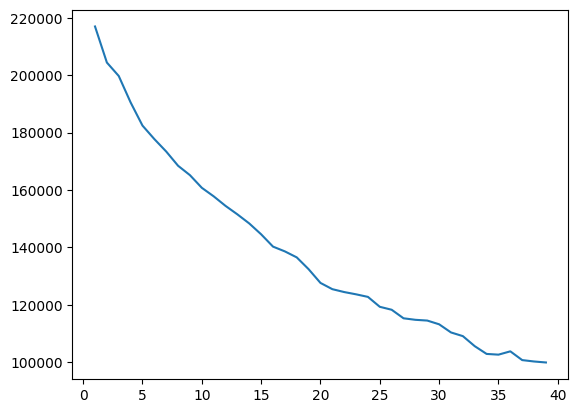

In [326]:
wcss=[]
for k in range(1,40):  # ( ]
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(processed_df)
    wcss.append(kmeans.inertia_)

sns.lineplot(x=range(1,40),y=wcss,palette='husl')
plt.show()

In [327]:
silhouette_scores = []
k_range = range(2, 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(processed_df)

    score = silhouette_score(processed_df, labels)
    silhouette_scores.append(score)
    print(f"k={k} | Silhouette Score: {score:.4f}")

k=2 | Silhouette Score: 0.0406
k=3 | Silhouette Score: 0.0467
k=4 | Silhouette Score: 0.0587
k=5 | Silhouette Score: 0.0718
k=6 | Silhouette Score: 0.0736
k=7 | Silhouette Score: 0.0811
k=8 | Silhouette Score: 0.0789
k=9 | Silhouette Score: 0.0783
k=10 | Silhouette Score: 0.0829
k=11 | Silhouette Score: 0.0933
k=12 | Silhouette Score: 0.0765
k=13 | Silhouette Score: 0.0840
k=14 | Silhouette Score: 0.0959
k=15 | Silhouette Score: 0.1010
k=16 | Silhouette Score: 0.1057
k=17 | Silhouette Score: 0.0993
k=18 | Silhouette Score: 0.0926
k=19 | Silhouette Score: 0.0954
k=20 | Silhouette Score: 0.0996
k=21 | Silhouette Score: 0.1240
k=22 | Silhouette Score: 0.1175
k=23 | Silhouette Score: 0.1142
k=24 | Silhouette Score: 0.1170
k=25 | Silhouette Score: 0.1254
k=26 | Silhouette Score: 0.1246
k=27 | Silhouette Score: 0.1236
k=28 | Silhouette Score: 0.1231
k=29 | Silhouette Score: 0.1178
k=30 | Silhouette Score: 0.1164
k=31 | Silhouette Score: 0.1220
k=32 | Silhouette Score: 0.1206
k=33 | Silhouett

##### The silhouette score gradually increases from 0.04 to 0.12 in k =39 therefore, it indicates that we still need to fix the data to get a higher score. 

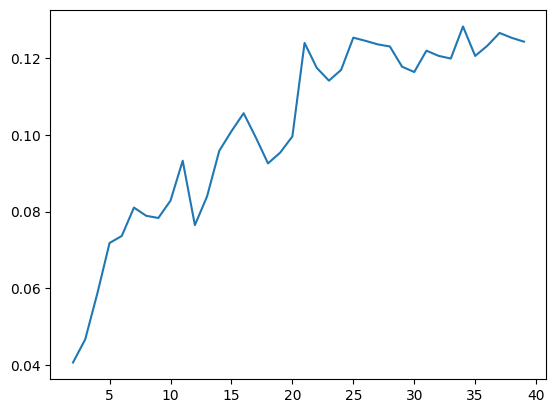

In [328]:
sns.lineplot(x=range(2,40),y=silhouette_scores,palette='husl')
plt.show()

##### To test a new result, we only pick the golumns 'poutcome', 'pdays', 'contact','previous', 'month', 'education', as they have the highest values in PCA loadings.

In [329]:
col_to_select = ['poutcome', 'pdays', 'contact','previous', 'month', 'education']
df = df[col_to_select]
df.head()

,poutcome,pdays,contact,previous,month,education
0,unknown,-1,cellular,0,oct,primary
1,failure,339,cellular,4,may,secondary
2,failure,330,cellular,1,apr,tertiary
3,unknown,-1,unknown,0,jun,tertiary
4,unknown,-1,unknown,0,may,secondary


In [330]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), cat_cols)],
    remainder='passthrough' 
)

pre_processor = Pipeline(steps=[
    ('encoder', encoder),
    ('scaler', StandardScaler())
])

processed_array = pre_processor.fit_transform(df)

new_column_names = pre_processor.get_feature_names_out()
processed_df = pd.DataFrame(data=processed_array, index=df.index, columns=new_column_names)

##### For the wcss it recued from the initial value of 200000 to 120000, meaning that the datapoints inside the each of the cluster are closer to thier respective cluster centres, for the same k value. 

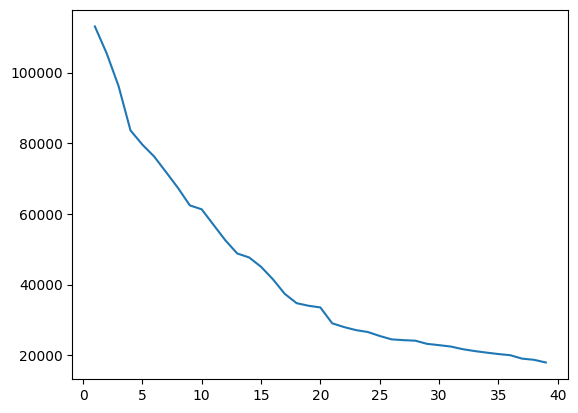

In [331]:
wcss=[]
for k in range(1,40):
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(processed_df)
    wcss.append(kmeans.inertia_)

sns.lineplot(x=range(1,40),y=wcss,palette='husl')
plt.show()

##### It following slihouette scores also gradually increases from 0.1 to 0.69 for k = 39, and it means that the data set have more distingushiable clusters when the cluster number is hight. But we can also see that the WCSS is getting smaller and smaller and we have to find the point based on the plots. 

In [332]:
silhouette_scores = []
k_range = range(2, 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(processed_df)

    score = silhouette_score(processed_df, labels)
    silhouette_scores.append(score)
    print(f"k={k} | Silhouette Score: {score:.4f}")

k=2 | Silhouette Score: 0.1122
k=3 | Silhouette Score: 0.1440
k=4 | Silhouette Score: 0.1942
k=5 | Silhouette Score: 0.2111
k=6 | Silhouette Score: 0.2199
k=7 | Silhouette Score: 0.2315
k=8 | Silhouette Score: 0.2592
k=9 | Silhouette Score: 0.3178
k=10 | Silhouette Score: 0.3183
k=11 | Silhouette Score: 0.3341
k=12 | Silhouette Score: 0.3485
k=13 | Silhouette Score: 0.3629
k=14 | Silhouette Score: 0.3780
k=15 | Silhouette Score: 0.4051
k=16 | Silhouette Score: 0.4192
k=17 | Silhouette Score: 0.4261
k=18 | Silhouette Score: 0.4416
k=19 | Silhouette Score: 0.4458
k=20 | Silhouette Score: 0.4494
k=21 | Silhouette Score: 0.5229
k=22 | Silhouette Score: 0.5562
k=23 | Silhouette Score: 0.5787
k=24 | Silhouette Score: 0.5813
k=25 | Silhouette Score: 0.5889
k=26 | Silhouette Score: 0.5967
k=27 | Silhouette Score: 0.5988
k=28 | Silhouette Score: 0.5963
k=29 | Silhouette Score: 0.5993
k=30 | Silhouette Score: 0.6021
k=31 | Silhouette Score: 0.6074
k=32 | Silhouette Score: 0.6326
k=33 | Silhouett

##### As the points are less steep around k = 9, and it is also the shilloutte value of around 0.3 for the point around k = 9 is chose to build the model. 

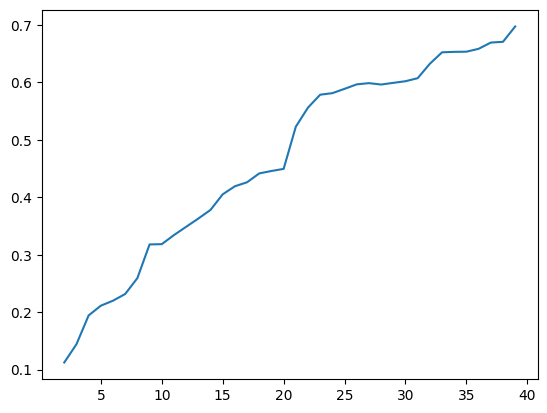

In [333]:
sns.lineplot(x=range(2,40),y=silhouette_scores,palette='husl')
plt.show()

In [334]:
encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', encoder),
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=9, random_state=42, n_init='auto'))
])

model = model_pipeline.fit(df)
model

,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [335]:
with open('bank_kmeans.pkl', 'wb') as f:
    joblib.dump(model, f)